# Загрузка данных и первичный осмотр

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("S02-hw-dataset.csv")
df.head()

,user_id,age,country,purchases,revenue
0,1,25.0,FR,7,749
1,2,24.0,RU,5,1115
2,3,52.0,FR,7,399
3,4,31.0,RU,6,654
4,5,NaN,DE,6,1296


Датасет содержит информацию о покупателях: возраст, страна, количество покупок и суммарная выручка

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    41 non-null     int64  
 1   age        39 non-null     float64
 2   country    41 non-null     object 
 3   purchases  41 non-null     int64  
 4   revenue    41 non-null     int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 1.7+ KB


Датасет содержит 41 запись о пользователях с id от 0 до 40. В колонке "age" есть два пропуска. Признак "county" является категориальным, остальные признаки числовые (при этом "age" - float64, вероятно правильнее было бы преобразовать его в int, так как в данном случае возраст - это целое число, а не дробное, т.е. сколько полных лет)

In [4]:
display(df.describe(include='all'))

,user_id,age,country,purchases,revenue
count,41.000000,39.000000,41,41.000000,41.000000
unique,NaN,NaN,5,NaN,NaN
top,NaN,NaN,RU,NaN,NaN
freq,NaN,NaN,13,NaN,NaN
mean,20.243902,36.512821,NaN,4.829268,820.048780
std,11.659289,18.304259,NaN,2.710189,613.127269
min,1.000000,5.000000,NaN,-1.000000,0.000000
25%,10.000000,24.000000,NaN,3.000000,432.000000
50%,20.000000,33.000000,NaN,5.000000,693.000000
75%,30.000000,45.500000,NaN,7.000000,1115.000000


Датасет содержит информацию о покупателях из 5 разных стран (5 уникальных значений в "country"). На основе первичного анализа можно выявить некоторые проблемы: 
1) В возрасте максимальное значение 120, которое скорее всего является ошибочным
2) Число покупок -1 невозможное значение


# Пропуски, дубликаты и базовый контроль качества

In [5]:
print(f"Количество пропусков:\n {df.isna().sum()}")
print(f"Доля пропусков:\n {df.isna().mean()}")
print("-"*40)
print(f"Количество полностью дублирующихся строк: {df.duplicated().sum()}")

Количество пропусков:
 user_id      0
age          2
country      0
purchases    0
revenue      0
dtype: int64
Доля пропусков:
 user_id      0.00000
age          0.04878
country      0.00000
purchases    0.00000
revenue      0.00000
dtype: float64
----------------------------------------
Количество полностью дублирующихся строк: 1


In [6]:
df[df.duplicated()] # Дублирующаяся строка

,user_id,age,country,purchases,revenue
40,10,24.0,RU,7,511


Найти и вывести «подозрительные» случаи, исходя из смысла датасета - ранее уже были выявлены некоторые выбросы, связанные с возрастом и количеством покупок. Рассмотрим более детально:

In [7]:
print(df['age'].unique())
print(df['country'].unique())
print(df['purchases'].unique())
print(df['revenue'].unique())

[ 25.  24.  52.  31.  nan 120.  46.  28.  39.  20.  36.  57.  22.  32.
  47.   5.  33.  42.  21.  35.  54.  43.  55.  26.  23.  45.  51.  18.
  34.]
['FR' 'RU' 'DE' 'CN' 'US']
[ 7  5  6 -1  0  2  4  9  3  8 11  1]
[ 749 1115  399  654 1296  785    0  456  980  511 1652  630 2358  693
  183 1608  432  442 1488  546  904 2475  650  330 1302  828 1440  702
  142 1080  445  404  342 1104  738 1162 2086]


In [8]:
df[df['age'].isna()]

,user_id,age,country,purchases,revenue
4,5,NaN,DE,6,1296
12,13,NaN,US,9,630


In [9]:
df[df['purchases'] < 0]

,user_id,age,country,purchases,revenue
5,6,120.0,FR,-1,785


In [10]:
df[(df['revenue'] == 0) & (df['purchases'] > 0)] # Нулевая выручка при наличии покупок

,user_id,age,country,purchases,revenue
10,11,24.0,US,4,0


In [11]:
df[(df['revenue'] > 0) & (df['purchases'] == 0)] # Ненулевая выручка без покупок

,user_id,age,country,purchases,revenue


Выводы: датасет имеет некоторые проблемные места, требующие обработки:
1) У пользователя с user_id = 6 значение возраста превышает предполагаемое допустимое значение, а так же количество покупок меньше 0, а сумма выручки при этом 785. Это очевидный выброс
2) У пользователей с user_id = 5 и 13 значение возраста вовсе не указано
3) У пользователя с user_id = 11 всего 4 покупки, однако общая выручка равна 0, что невозможно 
4) Пользователь с user_id = 10 дублируется

В остальном датасет выглядет корректно

# Базовый EDA: группировки, агрегаты и частоты

Единственный категориальный признак в представленном датасете - страна, будем анализировать его

In [12]:
print(df['country'].value_counts())

country
RU    13
FR    12
US     8
DE     6
CN     2
Name: count, dtype: int64


In [13]:
grouped = df.groupby('country').agg(
    avg_age=('age', 'mean'),
    total_purchases=('purchases', 'sum'),
    avg_revenue=('revenue', 'mean')
).round(2)

grouped.columns = ['Средний возраст', 'Количество покупок', 'Средняя выручка']
print(f"Группировка по странам:\n {grouped}")

Группировка по странам:
          Средний возраст  Количество покупок  Средняя выручка
country                                                      
CN                 24.00                   9          1054.00
DE                 34.60                  39          1445.50
FR                 46.25                  51           675.92
RU                 30.08                  62           790.08
US                 36.71                  37           557.38


In [14]:
df['age_group'] = pd.cut(df['age'], bins=[0, 25, 40, 60, 130], labels=['<20', '20–40', '40–60', '60+'], include_lowest=True)

age_groups_count = df['age_group'].value_counts()
print(f"Количество покупателей по возрастным группам:\n {age_groups_count}")

Количество покупателей по возрастным группам:
 age_group
20–40    14
<20      12
40–60    12
60+       1
Name: count, dtype: int64


На основе EDA можно сделать следующие выводы:
1) Чаще всего встречаются покупатели из России (RU) и Франции (FR), при этом меньше всего покупателей из Китая (CN)
2) При этом покупатели из Гермации (DE) являются самыми платежеспособными, так как имеют высокий средний чек
3) Cамые молодые покупатели в Китае, самые старшие во Франции
4) Самая массовая возрастная категория - от 20 до 40 лет

## Визуализация данных в Matplotlib

### Гистограмма для количественного признака

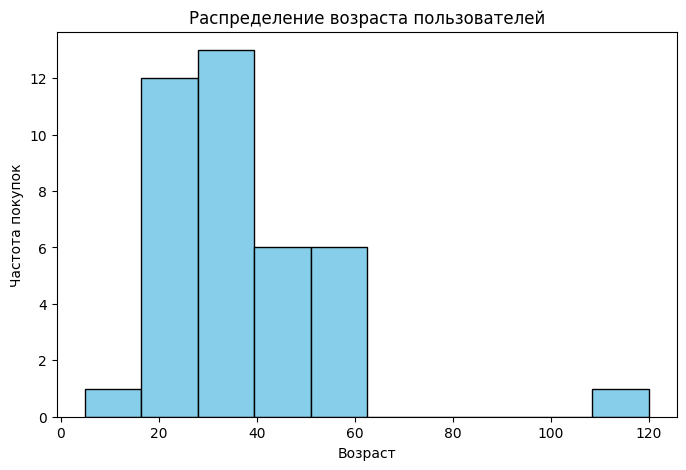

In [15]:
plt.figure(figsize=(8, 5))
plt.hist(df['age'].dropna(), bins=10, color='skyblue', edgecolor='black')
plt.title('Распределение возраста пользователей')
plt.xlabel('Возраст')
plt.ylabel('Частота покупок')
plt.savefig('figures/age_histogram.png')
plt.show()

Гистограмма отображает, как распределены покупатели по возрастным группам. Основная масса покупателей сосредоточена в возрастной группе 20–40 лет. Вторая по величине группа 0- 40–60 лет. Есть небольшая группа молодых пользователей до 20 лет и один выброс в 120 лет, который является аномалией. Это подтверждает ранее сделанные выводы

### Боксплот (boxplot) для количественного признака

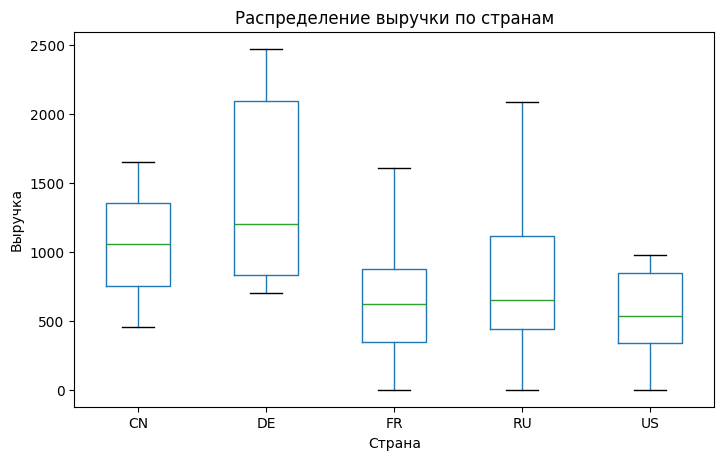

In [16]:
plt.figure(figsize=(8, 5))
df.boxplot(column='revenue', by='country', ax=plt.gca())
plt.title('Распределение выручки по странам')
plt.suptitle('') 
plt.xlabel('Страна')
plt.ylabel('Выручка')
plt.grid(False)
plt.savefig('figures/revenue_boxplot.png')
plt.show()

Боксплоты для каждой страны показывают разброс и центральные тенденции выручки. Германия (DE) имеет самую высокую среднюю выручку и наибольший разброс значений. Это указывает на наличие как низких, так и на высоких чеков покупателей. Россия (RU), Франция (FR) и Америка (US) показывают схожие медианные значения, но при этом у России больший верхний выброс (были покупатели с более высоким чеком)


### Scatter plot (диаграмма рассеяния) для пары количественных признаков

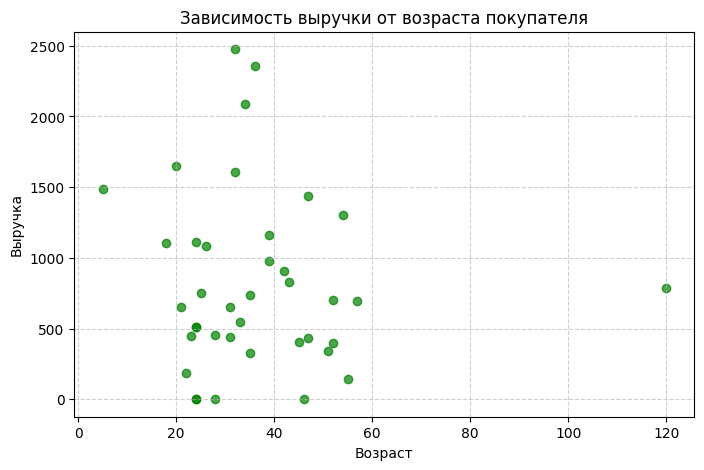

In [17]:
plt.figure(figsize=(8, 5))
plt.scatter(df['age'], df['revenue'], c='green', alpha=0.7)
plt.title('Зависимость выручки от возраста покупателя')
plt.xlabel('Возраст')
plt.ylabel('Выручка')
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('figures/age_vs_revenue_scatter.png')
plt.show()

Диаграмма рассеяния, где каждой точкой обозначен пользователь, по оси X возраст, а по оси Y выручка. Наблюдается несколько выбросов. Например, пользователь в возрасте около 35 лет с чеком около 2500 (скорее всего он из Германии, основываясь на прошлый график). При этом все пользователи от 20 до 60 лет имеют примерно одинаковую платежеспособность, есть и низкие и высокие чеки
